# Starbucks Capstone Challenge - Data Modeling

## <a id="load">Part I: Dependencies and data</a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots
sns.set()

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss,\
                            plot_confusion_matrix, classification_report as report


In [2]:
# Data
offers = pd.read_pickle('../data/output2/offers.pkl')
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 148430
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   index             148431 non-null  int64         
 1   event             148431 non-null  object        
 2   time              148431 non-null  int64         
 3   offer_id          148431 non-null  int32         
 4   user_id           148431 non-null  int64         
 5   amount            148431 non-null  float64       
 6   reward            148431 non-null  int64         
 7   difficulty        148431 non-null  int64         
 8   duration          148431 non-null  int64         
 9   offer_type        148431 non-null  object        
 10  mobile            148431 non-null  int64         
 11  social            148431 non-null  int64         
 12  web               148431 non-null  int64         
 13  expire_time       148431 non-null  int64         
 14  off_

## <a id="prep">Part II: Data Preprocessing</a>

#### 1. Extract offers

Aim is to predict whether a user will respond to an offer if it is sent to them. So we are interest in "offer received" events.

In [3]:
df = offers.query('event == "offer received"').copy()
df.head()

,index,event,time,offer_id,user_id,amount,reward,difficulty,duration,offer_type,...,signup_year,age_group,income_group,spend_group,frequency,monetary,tenure,user_tier,cluster,customer_cluster
0,0,offer received,0,7,2,0.0,5,5,7,bogo,...,2017,5,5,8,7,159.27,15,Yellow,0,Female low spenders
1,2,offer received,0,5,3,0.0,2,10,7,discount,...,2018,4,3,4,3,57.73,4,Red,3,Male low spenders
2,5,offer received,0,8,4,0.0,5,5,5,bogo,...,2018,4,2,3,3,36.43,6,Red,3,Male low spenders
3,7,offer received,0,1,5,0.0,0,0,4,informational,...,2017,3,2,2,3,15.62,9,Red,3,Male low spenders
4,8,offer received,0,6,6,0.0,5,20,10,discount,...,2017,4,2,5,6,85.55,11,Yellow,0,Female low spenders


In [4]:
# Drop columns that won't be used
col_drop = ['index', 'event', 'time', 'amount', 'expire_time', 'off_id_use_id',
           'user_date', 'signup_year', 'user_tier', 'customer_cluster', 'cluster']
df.drop(col_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66501 entries, 0 to 132146
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   offer_id      66501 non-null  int32  
 1   user_id       66501 non-null  int64  
 2   reward        66501 non-null  int64  
 3   difficulty    66501 non-null  int64  
 4   duration      66501 non-null  int64  
 5   offer_type    66501 non-null  object 
 6   mobile        66501 non-null  int64  
 7   social        66501 non-null  int64  
 8   web           66501 non-null  int64  
 9   viewed        66501 non-null  int64  
 10  completed     66501 non-null  int64  
 11  group         66501 non-null  int64  
 12  gender        66501 non-null  object 
 13  age           66501 non-null  int64  
 14  income        66501 non-null  int32  
 15  age_group     66501 non-null  int32  
 16  income_group  66501 non-null  int32  
 17  spend_group   66501 non-null  int32  
 18  frequency     66501 non-n

#### 2. Analyse Categorical variables

In [5]:
# offer type
df['info_offer'] = df.offer_type.apply(lambda t: int(t == 'informational'))
df['disc_offer'] = df.offer_type.apply(lambda t: int(t == 'discount'))
df['bogo_offer'] = df.offer_type.apply(lambda t: int(t == 'bogo'))
print(df.info_offer.sum(), df.disc_offer.sum(), df.bogo_offer.sum())
df.offer_type.value_counts()

13300 26664 26537


discount         26664
bogo             26537
informational    13300
Name: offer_type, dtype: int64

In [6]:
# gender
df['male'] = df.gender.apply(lambda g: int(g == 'M'))
print(df.male.sum())
df.gender.value_counts()

38129


M    38129
F    27456
O      916
Name: gender, dtype: int64

In [7]:
# Drop categorical columns
col_drop1 = ['offer_type', 'gender']
df.drop(col_drop1, axis=1, inplace=True)
df.shape

(66501, 23)

Drop the offer type and age column.

#### 3. Create target label

The target is to predict whether the offer is viewed and completed. If the offer is completed without viewing it first as user was not aware of the offer and spent the money anyway. This means there was no point in sending an offer to that customer.

In [8]:
df['target'] = df.apply(lambda o: int(o.viewed == o.completed == 1), axis=1)
df.target.value_counts()

0    38659
1    27842
Name: target, dtype: int64

In [9]:
df

,offer_id,user_id,reward,difficulty,duration,mobile,social,web,viewed,completed,...,income_group,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male,target
0,7,2,5,5,7,1,0,1,1,1,...,5,8,7,159.27,15,0,0,1,0,1
1,5,3,2,10,7,1,0,1,1,0,...,3,4,3,57.73,4,0,1,0,1,0
2,8,4,5,5,5,1,1,1,1,1,...,2,3,3,36.43,6,0,0,1,1,1
3,1,5,0,0,4,1,0,1,0,0,...,2,2,3,15.62,9,1,0,0,1,0
4,6,6,5,20,10,0,0,1,1,0,...,2,5,6,85.55,11,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132142,9,14788,10,10,7,1,1,0,0,1,...,2,10,10,530.96,22,0,0,1,1,0
132143,5,14820,2,10,7,1,0,1,0,0,...,5,7,5,115.59,3,0,1,0,1,0
132144,3,14821,3,7,7,1,1,1,1,0,...,2,2,7,20.03,2,0,1,0,0,0
132145,9,14824,10,10,7,1,1,0,0,1,...,2,9,14,189.67,30,0,0,1,0,0


In [10]:
drop_col = ['offer_id', 'user_id', 'age_group', 'income_group', 'viewed', 'completed', 'group']
df.drop(drop_col, axis=1, inplace=True)
df.shape

(66501, 17)

#### 4. Target variable

In [11]:
df = pd.concat([df.query('target == 1'), df.query('target == 0').sample(27842, random_state=0)]).sort_index()
print(df.shape)
df.head()

(55684, 17)


,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male,target
0,5,5,7,1,0,1,75,100000,8,7,159.27,15,0,0,1,0,1
1,2,10,7,1,0,1,68,70000,4,3,57.73,4,0,1,0,1,0
2,5,5,5,1,1,1,65,53000,3,3,36.43,6,0,0,1,1,1
3,0,0,4,1,0,1,58,51000,2,3,15.62,9,1,0,0,1,0
4,5,20,10,0,0,1,61,57000,5,6,85.55,11,0,1,0,0,0


In [12]:
df.target.value_counts()

1    27842
0    27842
Name: target, dtype: int64

#### 5. Split data into 3 sets

In [13]:
X = df.drop('target', axis=1).copy() # features
Y = df['target'].copy() # target label
X.shape, Y.shape

((55684, 16), (55684,))

In [14]:
# Split test and train set (50%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, random_state=0)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((27842, 16), (27842, 16), (27842,), (27842,))

In [15]:
# Second split - validation and test sets (50% each)
X_valid, X_testv, Y_valid, Y_testv = train_test_split(X_test, Y_test, train_size=0.5, random_state=0)
X_valid.shape, X_testv.shape, Y_valid.shape, Y_testv.shape

((13921, 16), (13921, 16), (13921,), (13921,))

In [16]:
# Class ratio for train and test sets
print('Proportion of offers completed in:')
print('Train set:', Y_train.mean())
print('Validation set:', Y_valid.mean())
print('Test set:', Y_testv.mean())

Proportion of offers completed in:
Train set: 0.5041304503986782
Validation set: 0.4928525249622872
Test set: 0.4988865742403563


#### 6.Correlation

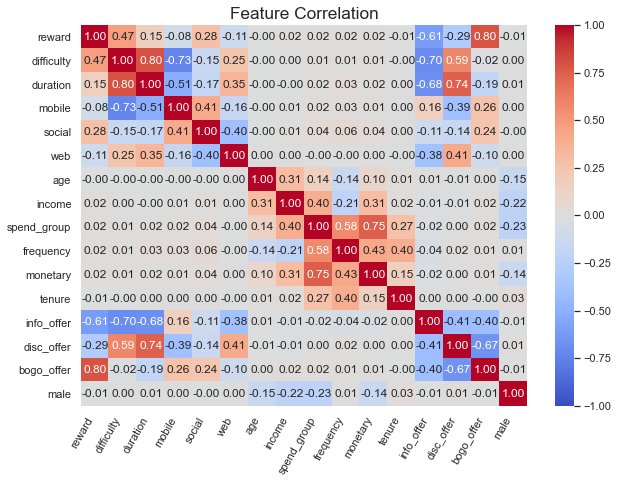

In [17]:
plt.figure(figsize=(10,7))
sns.heatmap(X_train.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation', fontsize='x-large')
plt.xticks(rotation=60, ha='right');

In [18]:
high_corr = ['duration', 'mobile', 'info_offer', 'disc_offer', 'bogo_offer']
low_corr_feats = np.setdiff1d(X_train.columns, high_corr)
low_corr_feats

array(['age', 'difficulty', 'frequency', 'income', 'male', 'monetary',
       'reward', 'social', 'spend_group', 'tenure', 'web'], dtype=object)

High corelation is found with the 3 `offer type` binary features, 3 `channel` binary features and `duration` feature. These features won't be dropped as they may be good predictors for tree-based classifiers, but they will be omitted from classification algorithms where there is an assumption of no corelation.

#### 7. Normalization

In [19]:
# Normalize train set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled.head()

,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-0.343060,-0.115666,0.226598,0.321961,0.787665,0.501997,0.318390,-0.496159,0.780391,0.353737,0.216699,-0.810329,-0.500763,1.210456,-0.806101,-1.142028
1,0.245629,-0.482721,-0.679535,0.321961,0.787665,0.501997,1.184593,0.435514,-0.266809,-0.864262,-0.431199,-0.738585,-0.500763,-0.826135,1.240540,0.875635
2,-0.343060,-0.115666,0.226598,0.321961,0.787665,0.501997,1.126846,0.435514,0.780391,-0.458262,0.186267,0.265837,-0.500763,1.210456,-0.806101,0.875635
3,0.245629,-0.482721,-0.679535,0.321961,0.787665,0.501997,-0.778801,-1.334665,-1.663075,-0.864262,-0.839462,-0.810329,-0.500763,-0.826135,1.240540,-1.142028
4,0.245629,-0.482721,0.226598,0.321961,-1.269575,0.501997,0.664871,-0.076906,-1.663075,-1.067262,-0.836301,-0.810329,-0.500763,-0.826135,1.240540,0.875635


In [20]:
# Normalize validation set
X_val_scaled = scaler.transform(X_valid)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_valid.columns)
X_val_scaled.head()

,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,-1.226094,-1.400360,-1.132601,0.321961,-1.269575,0.501997,-1.183029,-0.915412,-1.663075,-1.473261,-0.917086,-0.666840,1.996952,-0.826135,-0.806101,-1.142028
1,0.245629,-0.482721,0.226598,0.321961,-1.269575,0.501997,-0.721054,-0.449575,-0.615875,-1.067262,-0.590858,-0.882074,-0.500763,-0.826135,1.240540,0.875635
2,0.245629,2.270196,1.585798,-3.105968,-1.269575,0.501997,-1.471764,-0.309824,-0.266809,1.977735,-0.335639,2.992126,-0.500763,1.210456,-0.806101,0.875635
3,-0.343060,-0.115666,0.226598,0.321961,0.787665,0.501997,-0.778801,0.482098,1.129457,0.150737,0.593574,-0.092885,-0.500763,1.210456,-0.806101,0.875635
4,-1.226094,-1.400360,-1.585668,0.321961,0.787665,-1.992043,-1.414017,-1.614166,-0.266809,1.165736,-0.299914,-0.092885,1.996952,-0.826135,-0.806101,-1.142028


In [21]:
# Normalize test set
X_test_scaled = scaler.transform(X_testv)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_testv.columns)
X_test_scaled.head()

,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,1.717352,0.434918,0.226598,0.321961,0.787665,-1.992043,2.108544,1.180852,1.129457,-0.052263,0.451777,-0.021140,-0.500763,-0.826135,1.240540,0.875635
1,1.717352,0.434918,-0.679535,0.321961,0.787665,0.501997,0.953606,-0.682493,0.431324,0.759736,0.038663,-0.810329,-0.500763,-0.826135,1.240540,0.875635
2,-0.343060,-0.115666,0.226598,0.321961,0.787665,0.501997,0.087402,1.134269,1.129457,0.353737,0.630768,2.346426,-0.500763,1.210456,-0.806101,0.875635
3,-0.637405,0.434918,0.226598,0.321961,-1.269575,0.501997,1.935303,-0.402992,0.431324,-0.052263,-0.060205,0.050604,-0.500763,1.210456,-0.806101,0.875635
4,-1.226094,-1.400360,-1.585668,0.321961,0.787665,-1.992043,1.300087,-0.402992,-0.266809,-0.458262,-0.296092,2.920382,1.996952,-0.826135,-0.806101,-1.142028


In [22]:
del X_test, Y_test, high_corr, drop_col
gc.collect()

19937

With the data preprocessed, we are left with 2 feature sets:
1. Set 1 with 8 features (features with high correlation) - `age`, `difficulty`, `frequency`, `income`, `male`, `monetary`, `reward`, `tenure`
2. Set 2 with 15 features - the features in set 1 plus `duration`, `mobile`, `social`, `web`, `info_offers`, `disc_offer`, `bogo_offer`

## <a id="clfr">Part III: Modeling</a>

#### 1. Feature correlation with target

In [23]:
# Correlation with target variable
target_corr = X_train.assign(target = Y_train).corr().iloc[-1, :-1].sort_values(ascending=False)
target_corr

spend_group    0.423769
frequency      0.286134
monetary       0.283780
social         0.219021
mobile         0.158905
tenure         0.156796
income         0.115038
age            0.060317
disc_offer     0.039845
info_offer    -0.001984
web           -0.004990
duration      -0.017640
bogo_offer    -0.038416
reward        -0.059269
male          -0.091544
difficulty    -0.099235
Name: target, dtype: float64

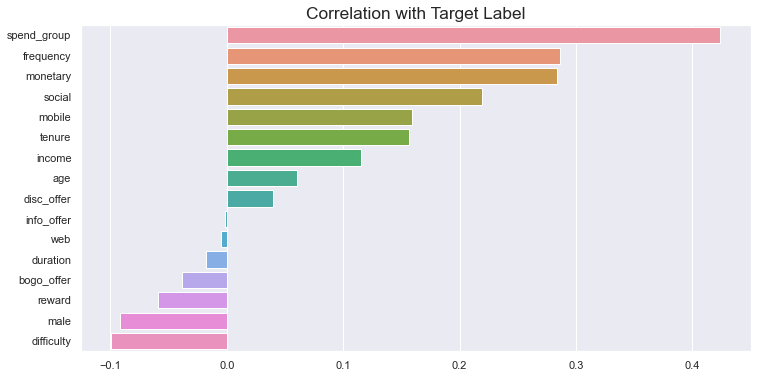

In [24]:
plt.figure(figsize=(12, 6))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation with Target Label', fontsize='x-large');

Above barplot shows that the spending habits of a customer would be the best predictor.

#### 2. Evaluation functions

In [25]:
def model_evalution(train_pred, val_pred, test_pred=None,
               train_true=Y_train, val_true=Y_valid, test_true=Y_testv):
    
    '''
    Get the accuracy and ROC-AUC scores of the train, validation, and test sets.
    
    Args:
        (1) train_pred (array-like) - predictions on training set
        (2) val_pred (array-like) - predictions on validation set
        (3) test_pred (array-like) - predictions on test set
        (4) train_true (array-like) - true labels from train set
        (5) val_true (array-like) - true labels from validation set
        (6) test_true (array-like) - true labels from test set
        
    Returns:
        Accuracy and ROC-AUC scores of the train, validation, and test sets (Pandas dataframe)
    '''
    
    metrics = dict()
    
    if train_pred is not None:
        metrics['train'] = [accuracy_score(train_true, train_pred)]
        metrics['train'].append(roc_auc_score(train_true, train_pred))
        
    if val_pred is not None:
        metrics['validation'] = [accuracy_score(val_true, val_pred)]
        metrics['validation'].append(roc_auc_score(val_true, val_pred))
        
    if test_pred is not None:
        metrics['test'] = [accuracy_score(test_true, test_pred)]
        metrics['test'].append(roc_auc_score(test_true, test_pred))
        
    return pd.DataFrame(metrics, index=['accuracy', 'ROC-AUC score']).T

In [26]:
def plot_confusionmatrix(estimator, n_subplots, train_X, val_X, test_X=None,
                   train_y=Y_train, val_y=Y_valid, test_y=Y_testv, color='Blues'):
    
    '''
    Plot a heatmap of the confusion matrix for the train, validation, and test sets.
    
    Args:
        (1) estimator (Sklearn estimator) - fitted classifier
        (2) n_subplots (int) - number of sets to plot for
        (3) train_X (Pandas dataframe) - X from training set
        (4) val_X (Pandas dataframe) - X from validation set
        (5) test_X (Pandas dataframe) - X from test set
        (6) train_y (Pandas dataframe) - y from training set
        (7) val_y (Pandas dataframe) - y from validation set
        (8) test_y (Pandas dataframe) - y from test set
        
    Returns: None.
    '''
    
    fig, ax = plt.subplots(1, n_subplots, figsize=(15, 3))
    i = 0
    
    if train_X is not None:
        plot_confusion_matrix(estimator, train_X, train_y, cmap=color, ax=ax[i])
        ax[i].set_title('Train Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if val_X is not None:
        plot_confusion_matrix(estimator, val_X, val_y, cmap=color, ax=ax[i])
        ax[i].set_title('Validation Confusion Matrix')
        ax[i].grid(False)
        i += 1
        
    if test_X is not None:
        plot_confusion_matrix(estimator, test_X, test_y, cmap=color, ax=ax[i])
        ax[i].set_title('Test Confusion Matrix')
        ax[i].grid(False)

#### 3. Logistic regression

In [27]:
X_train_scaled_sub = X_train_scaled[low_corr_feats]
X_val_scaled_sub = X_val_scaled[low_corr_feats]
X_test_scaled_sub = X_test_scaled[low_corr_feats]
X_train_scaled_sub.shape, X_val_scaled_sub.shape, X_test_scaled_sub.shape

((27842, 11), (13921, 11), (13921, 11))

In [28]:
%%time

# Grid Search
lr = LogisticRegression(random_state=0)
lr_params = {'C': np.logspace(-3, 1, 10),
             'penalty': ['l1', 'l2']}

lr_search = GridSearchCV(lr, lr_params, scoring='roc_auc', cv=10, n_jobs=4, verbose=2)
lr_search.fit(X_train_scaled_sub, Y_train)
print(lr_search.best_score_)
print(lr_search.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 193 out of 200 | elapsed:  1.1min remaining:    2.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  1.1min finished


0.7902891432180298
{'C': 0.021544346900318832, 'penalty': 'l2'}
Wall time: 1min 7s


In [29]:
# Train model
lr = lr_search.best_estimator_
lr.fit(X_train_scaled_sub, Y_train)

# Make predictions
lr_train_pred = lr.predict(X_train_scaled_sub)
lr_val_pred = lr.predict(X_val_scaled_sub)

# Evaluate predictions
print(report(Y_train, lr_train_pred))
print(report(Y_valid, lr_val_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     13806
           1       0.71      0.73      0.72     14036

    accuracy                           0.72     27842
   macro avg       0.72      0.72      0.72     27842
weighted avg       0.72      0.72      0.72     27842

              precision    recall  f1-score   support

           0       0.73      0.70      0.72      7060
           1       0.71      0.73      0.72      6861

    accuracy                           0.72     13921
   macro avg       0.72      0.72      0.72     13921
weighted avg       0.72      0.72      0.72     13921



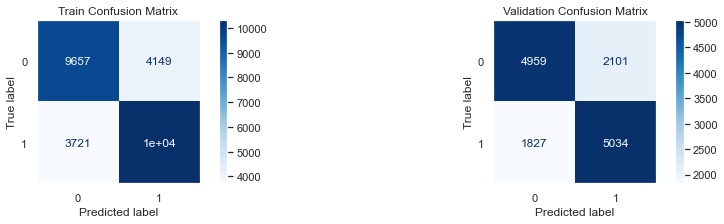

In [30]:
# Confusion matrix
plot_confusionmatrix(lr, 2, X_train_scaled_sub, X_val_scaled_sub)

In [31]:
# Coefficients
pd.Series(lr.coef_[0], index=X_train_scaled_sub.columns).sort_values(ascending=False)

spend_group    1.162049
social         0.686817
web            0.248425
tenure         0.098713
age            0.050179
frequency      0.034285
male          -0.018880
difficulty    -0.089333
income        -0.142452
monetary      -0.176897
reward        -0.295833
dtype: float64

The logistic regression model achieved an prediction accuracy and f1-score of 0.72 for both the training and validation sets.

It looks like the `social`, `frequency`, and `monetary` features have the most predictive power in this model. The posistive relationship between the customer's spending habits and their likelihood of completing an offer agrees with the analysis from the previous notebooks, but it's interesting to see that sending the offer through social media has an even greater importance here. Perhaps this is the main channel in which customers are responding to offers.

Surprisingly, `reward` has a negative coefficient, which is counterintuitive because one would expect that reward has a positive relationship with offer completion. Of course, this doesn't imply that lowering rewards would increase offer completions. It could just be that informational offers (which have 0 `reward`) are pulling this coefficient in the negative direction.

#### 4. K-nearest Neighbors

Wall time: 4min 6s


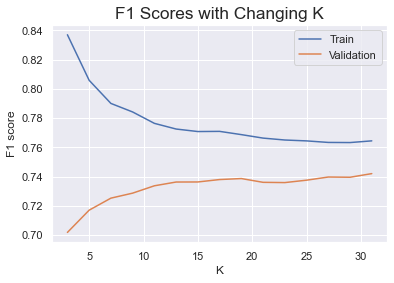

In [32]:
%%time

# Find optimal range for K
auc_train, auc_val = [], []
for k in range(3, 33, 2):
    
    # Train model
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train_scaled, Y_train)
    
    # Make predictions
    k_train_pred = knn_k.predict(X_train_scaled)
    k_val_pred = knn_k.predict(X_val_scaled)
    
    # F1 scores
    auc_train.append(f1_score(Y_train, k_train_pred))
    auc_val.append(f1_score(Y_valid, k_val_pred))

# Plot scores
sns.lineplot(x=range(3, 33, 2), y=auc_train)
sns.lineplot(x=range(3, 33, 2), y=auc_val)
plt.title('F1 Scores with Changing K', fontsize='x-large')
plt.ylabel('F1 score')
plt.xlabel('K')
plt.legend(['Train', 'Validation']);

In [33]:
%%time

knn = KNeighborsClassifier()
knn_param = {'n_neighbors': [5, 10, 30, 50],
              'p': [1, 2, 3, 4]}

knn_search = GridSearchCV(knn, knn_param, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
knn_search.fit(X_train_scaled, Y_train)
print(knn_search.best_score_)
print(knn_search.best_params_)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:  3.6min finished


0.8136713841073357
{'n_neighbors': 50, 'p': 1}
Wall time: 3min 39s


In [34]:
# Train model
knn = knn_search.best_estimator_
knn.fit(X_train_scaled, Y_train)

# Make predictions
knn_train_pred = knn.predict(X_train_scaled)
knn_val_pred = knn.predict(X_val_scaled)

# Evaluate predictions
print(report(Y_train, knn_train_pred))
print(report(Y_valid, knn_val_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     13806
           1       0.74      0.77      0.76     14036

    accuracy                           0.75     27842
   macro avg       0.75      0.75      0.75     27842
weighted avg       0.75      0.75      0.75     27842

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7060
           1       0.72      0.76      0.74      6861

    accuracy                           0.74     13921
   macro avg       0.74      0.74      0.74     13921
weighted avg       0.74      0.74      0.74     13921



The K-nearest neighbors algorithm does better than logistic regression in making predictions on the validation set, with a f1-score of 0.74.

Once again, only 2 parameters were tuned: `n_neighbors` (the core of this algorithm) and `d` (the polynomial for the distance function). The best values were:
- `n_neighbors`: 50 - this means that in order to classify any new data point, KNN will find its 50 closest neighbors and take the major class of the neighbors
    - As seen in the line plot of F1 scores for the train and validation sets with a varying k, the validation set's f1-score converges to somewhere around 0.74 when going beyond a k of 30
    - I stopped at 50 neighbors in the parameter grid because any more would add unnecessary runtime for a minimal gain in score
- `d`: 1 - a polynomial of 1 means the Manhattan distance will be used to compute distances between data points

#### 5. Support Vector Machines

In [35]:
%%time

# Grid search
svm = SVC()
svm_params = {'C': np.logspace(-1, 3, 5),
              'gamma': np.logspace(-3, 1, 5)}

svm_search = GridSearchCV(svm, svm_params, scoring='roc_auc', cv=3, n_jobs=4, verbose=2)
svm_search.fit(X_train_scaled, Y_train)
print(svm_search.best_score_)
print(svm_search.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed: 47.4min finished


0.8093619748378199
{'C': 100.0, 'gamma': 0.01}
Wall time: 1h 3s


In [37]:
# Train model
svm = svm_search.best_estimator_
svm.fit(X_train_scaled, Y_train)

# Make predictions
svm_train_pred = svm.predict(X_train_scaled)
svm_val_pred = svm.predict(X_val_scaled)

# Evaluate predictions
print(report(Y_train, svm_train_pred))
print(report(Y_valid, svm_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72     13806
           1       0.72      0.80      0.76     14036

    accuracy                           0.74     27842
   macro avg       0.74      0.74      0.74     27842
weighted avg       0.74      0.74      0.74     27842

              precision    recall  f1-score   support

           0       0.78      0.68      0.72      7060
           1       0.71      0.80      0.75      6861

    accuracy                           0.74     13921
   macro avg       0.74      0.74      0.74     13921
weighted avg       0.74      0.74      0.74     13921



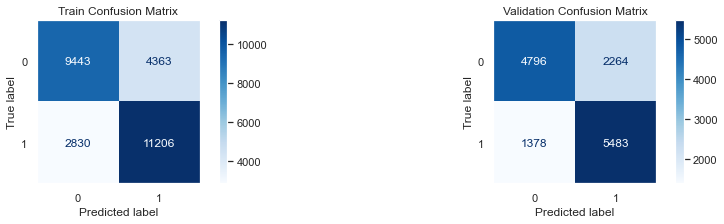

In [38]:
### Confusion matrix
plot_confusionmatrix(svm, 2, X_train_scaled, X_val_scaled)

Compared to KNN, SVM does better overall with f1-score of 0.74. Predictions of the positive class outnumbered the negative class in the ratio 3:2. 

SVM takes longer time for prediction though only 2 variables are considered.
- `C`: 100 - this is the same `C` as in logistic regression, i.e. the inverse of regularization strength
- `gamma`: 0.01 - this is the kernel coefficient used in refining the decision boundary, most often less than 1

#### 6. Decision tree

In [39]:
%%time

# Grid search
dt = DecisionTreeClassifier(random_state=0)
dt_params = {'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, None],
             'min_samples_split': [100, 60, 20, 2],
             'min_samples_leaf': [50, 30, 10, 1]}

dt_search = GridSearchCV(dt, dt_params, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
dt_search.fit(X_train_scaled, Y_train)
print(dt_search.best_score_)
print(dt_search.best_params_)

Fitting 4 folds for each of 256 candidates, totalling 1024 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 252 tasks      | elapsed:   38.5s
[Parallel(n_jobs=4)]: Done 658 tasks      | elapsed:   55.4s
[Parallel(n_jobs=4)]: Done 1024 out of 1024 | elapsed:  1.3min finished


0.8107334507754475
{'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 50, 'min_samples_split': 100}
Wall time: 1min 15s


In [40]:
# Train model
dt = dt_search.best_estimator_
dt.fit(X_train_scaled, Y_train)

# Make predictions
dt_train_pred = dt.predict(X_train_scaled)
dt_val_pred = dt.predict(X_val_scaled)

# Evaluate predictions
print(report(Y_train, dt_train_pred))
print(report(Y_valid, dt_val_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73     13806
           1       0.73      0.80      0.76     14036

    accuracy                           0.75     27842
   macro avg       0.75      0.75      0.75     27842
weighted avg       0.75      0.75      0.75     27842

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      7060
           1       0.71      0.79      0.75      6861

    accuracy                           0.74     13921
   macro avg       0.74      0.74      0.74     13921
weighted avg       0.74      0.74      0.74     13921



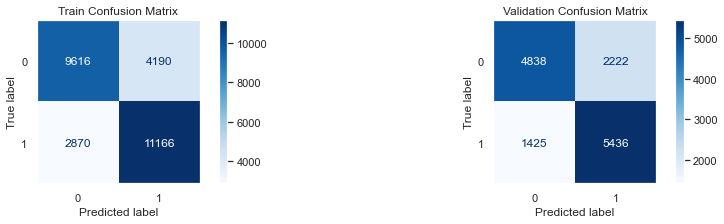

In [41]:
# Confusion matrix
plot_confusionmatrix(dt, 2, X_train_scaled, X_val_scaled)

In [42]:
# Feature importances
pd.Series(dt.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

monetary       0.609520
social         0.106577
reward         0.080602
frequency      0.063414
duration       0.038556
income         0.030457
bogo_offer     0.014574
difficulty     0.014423
age            0.011247
disc_offer     0.011211
tenure         0.007741
spend_group    0.006489
info_offer     0.002391
male           0.001994
web            0.000804
mobile         0.000000
dtype: float64

Just as with logistic regression, `monetary`, `social`, and `frequency` are the top 3 most important features in the same order. So the decision tree algorithm agrees that the most important predictors are the user's spending habits and social media. 

#### 7. Random forest

In [43]:
%%time

# Grid search
rf = RandomForestClassifier(random_state=0)
rf_params = {'max_samples': [0.4, 0.6, 0.8, None],
             'max_features': [0.25, 0.5, 0.75, None],
             'max_depth': [8, 10, 12, None],
             'min_samples_split': [100, 60, 20, 2],
             'min_samples_leaf': [50, 30, 10, 1]}

rf_search = GridSearchCV(rf, rf_params, scoring='roc_auc', cv=4, n_jobs=4, verbose=2)
rf_search.fit(X_train_scaled, Y_train)
print(rf_search.best_score_)
print(rf_search.best_params_)

Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed: 27.6min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed: 32.5min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed: 43.0min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed: 52.1min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 65.9min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 125.2min
[Parallel(n_jobs=4)]: Done 4096 out of 4096 | elapsed: 128.7min finished


0.8234131545875452
{'max_depth': None, 'max_features': 0.5, 'max_samples': 0.4, 'min_samples_leaf': 10, 'min_samples_split': 60}
Wall time: 2h 8min 49s


In [44]:
%%time

# Train model
rf = RandomForestClassifier(n_estimators=1000,
                            max_samples=0.8,
                            max_features=0.5,
                            min_samples_split=100,
                            min_samples_leaf=10,
                            random_state=0,
                            n_jobs=-1)
rf.fit(X_train_scaled, Y_train)

# Make predictions
rf_train_pred = rf.predict(X_train_scaled)
rf_val_pred = rf.predict(X_val_scaled)

# Evaluate predictions
print(report(Y_train, rf_train_pred))
print(report(Y_valid, rf_val_pred))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76     13806
           1       0.75      0.81      0.78     14036

    accuracy                           0.77     27842
   macro avg       0.77      0.77      0.77     27842
weighted avg       0.77      0.77      0.77     27842

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      7060
           1       0.73      0.78      0.76      6861

    accuracy                           0.75     13921
   macro avg       0.75      0.75      0.75     13921
weighted avg       0.75      0.75      0.75     13921

Wall time: 17.9 s
Parser   : 121 ms


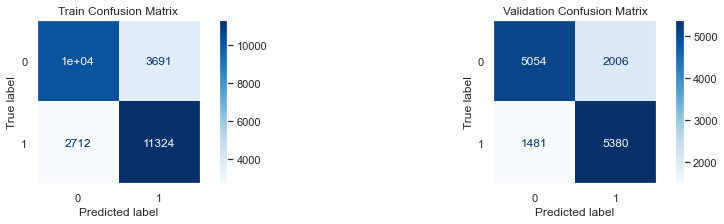

In [45]:
# Confusion matrix
plot_confusionmatrix(rf, 2, X_train_scaled, X_val_scaled)

In [46]:
# Feature importances
pd.Series(rf.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

monetary       0.363497
spend_group    0.147780
frequency      0.103544
social         0.100120
income         0.057608
tenure         0.045053
age            0.041111
reward         0.039779
difficulty     0.027711
disc_offer     0.020832
duration       0.018059
mobile         0.013611
bogo_offer     0.008280
web            0.006508
male           0.003719
info_offer     0.002791
dtype: float64

Since random forest is just ensembling decision trees, the top 4 features are `monetary`, `spend_group`, `frequency`, and `social`, although the coefficients did change.

The same 4 parameters tuned with decision tree are done here as well with the same values. `Max_samples` are added to the grid to add more randomness to the model. This parameter limits the size of the training data each tree is trained on.  The best values are:
- `max_samples`: 0.4
- `max_features`: 0.5
- `max_depth`: None
- `min_samples_split`: 60
- `min_samples_leaf`: 10

Random forest does better than decision tree.

Up till now, SVM and random forest have done the best, both with an F1-score of 0.74 and 0.75 on the validation set. Random forest does slightly better, but it does take a lot more time and resource to run, so there's that tradeoff. We will compare both on the final test set.

#### 8. Final classifier

In [47]:
# SVM predictions on test set
svm_test_pred = svm.predict(X_test_scaled)

# Evaluate predictions
print(report(Y_valid, svm_val_pred))
print(report(Y_testv, svm_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.68      0.72      7060
           1       0.71      0.80      0.75      6861

    accuracy                           0.74     13921
   macro avg       0.74      0.74      0.74     13921
weighted avg       0.74      0.74      0.74     13921

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      6976
           1       0.71      0.80      0.75      6945

    accuracy                           0.74     13921
   macro avg       0.74      0.74      0.74     13921
weighted avg       0.74      0.74      0.74     13921



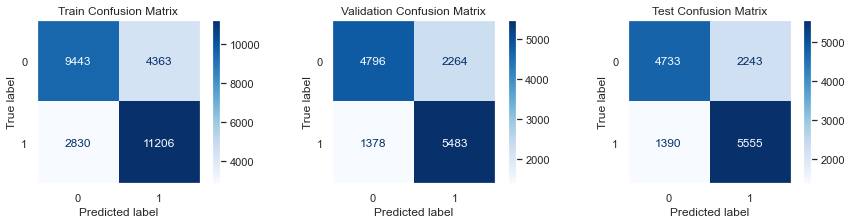

In [48]:
### Confusion matrix
plot_confusionmatrix(svm, 3, X_train_scaled, X_val_scaled, X_test_scaled)

In [49]:
# Random forest predictions on test set
rf_test_pred = rf.predict(X_test_scaled)

# Evaluate predictions
print(report(Y_valid, rf_val_pred))
print(report(Y_testv, rf_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      7060
           1       0.73      0.78      0.76      6861

    accuracy                           0.75     13921
   macro avg       0.75      0.75      0.75     13921
weighted avg       0.75      0.75      0.75     13921

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      6976
           1       0.73      0.78      0.75      6945

    accuracy                           0.74     13921
   macro avg       0.75      0.74      0.74     13921
weighted avg       0.75      0.74      0.74     13921



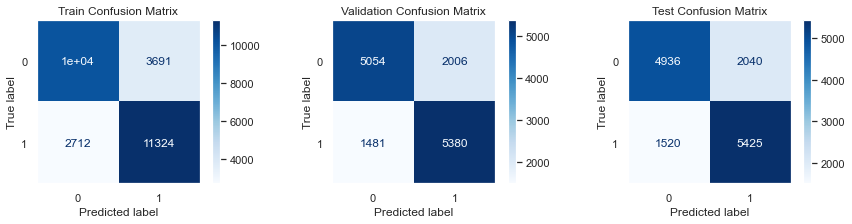

In [51]:
### Confusion matrix
plot_confusionmatrix(rf, 3, X_train_scaled, X_val_scaled, X_test_scaled)

We will be going with random forest as it outperformed SVM in both the validation and test sets. By examining its predictions, we may be able to see differences in demographics and behavior. This is actually a similar approach to segmentation, but we won't be segmenting customers. Instead, we are segmenting the unique offers that went out to customers.

In [52]:
# Normalize the entire dataset
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print(X_scaled.shape)
X_scaled.head()

(55684, 16)


,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,0.243966,-0.485470,0.223610,0.321859,-1.263613,0.50009,1.182039,1.591093,0.781839,-0.253960,0.247765,-0.234072,-0.497788,-0.824874,1.233708,-1.139486
1,-0.640571,0.433579,0.223610,0.321859,-1.263613,0.50009,0.778388,0.198961,-0.614057,-1.066293,-0.507030,-1.024845,-0.497788,1.212306,-0.810565,0.877589
2,0.243966,-0.485470,-0.683471,0.321859,0.791382,0.50009,0.605395,-0.589914,-0.963031,-1.066293,-0.665363,-0.881068,-0.497788,-0.824874,1.233708,0.877589
3,-1.230263,-1.404519,-1.137011,0.321859,-1.263613,0.50009,0.201744,-0.682722,-1.312005,-1.066293,-0.820053,-0.665403,2.008888,-0.824874,-0.810565,0.877589
4,0.243966,2.271678,1.584231,-3.106951,-1.263613,0.50009,0.374738,-0.404296,-0.265083,-0.457043,-0.300231,-0.521626,-0.497788,1.212306,-0.810565,-1.139486


              precision    recall  f1-score   support

           0       0.78      0.72      0.75     27842
           1       0.74      0.79      0.77     27842

    accuracy                           0.76     55684
   macro avg       0.76      0.76      0.76     55684
weighted avg       0.76      0.76      0.76     55684



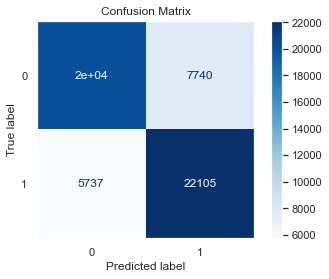

In [53]:
# Make predictions on the entire dataset
rf_pred = rf.predict(X_scaled)

# Evaluate predictions
print(report(Y, rf_pred))
plot_confusion_matrix(rf, X_scaled, Y, cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False);

In [54]:
# Inspect average values for each predicted class
X['prediction'] = rf_pred
label_means = X.groupby('prediction').mean()
label_means = label_means.append(X.mean()[:-1], ignore_index=True)
label_means

,reward,difficulty,duration,mobile,social,web,age,income,spend_group,frequency,monetary,tenure,info_offer,disc_offer,bogo_offer,male
0,4.289407,8.550718,6.666589,0.827083,0.425287,0.822903,52.874686,62490.421456,3.795232,5.972638,62.342470,14.462402,0.196099,0.406053,0.397848,0.629939
1,4.071402,6.853677,6.368772,0.974569,0.779058,0.780064,55.909767,68501.993634,7.460312,10.222650,180.999248,21.540493,0.200737,0.403920,0.395343,0.508628
2,4.172563,7.641154,6.506968,0.906131,0.614898,0.799943,54.501401,65712.448818,5.759608,8.250521,125.939043,18.256052,0.198585,0.404910,0.396505,0.564920


([<matplotlib.axis.XTick at 0x27bad59ba90>,
 [Text(0, 0, 'reward'),
  Text(1, 0, 'difficulty'),
  Text(2, 0, 'duration'),
  Text(3, 0, 'mobile'),
  Text(4, 0, 'social'),
  Text(5, 0, 'web'),
  Text(6, 0, 'age'),
  Text(7, 0, 'income'),
  Text(8, 0, 'spend_group'),
  Text(9, 0, 'frequency'),
  Text(10, 0, 'monetary'),
  Text(11, 0, 'tenure'),
  Text(12, 0, 'info_offer'),
  Text(13, 0, 'disc_offer'),
  Text(14, 0, 'bogo_offer'),
  Text(15, 0, 'male')])

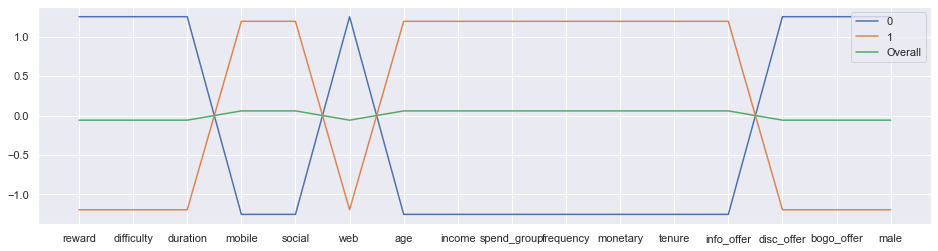

In [57]:
# Snake plot
pd.DataFrame(StandardScaler().fit_transform(label_means), index=[0, 1, 'Overall'], columns=label_means.columns).T.plot(figsize=(16, 4))
plt.xticks(range(16), label_means.columns)

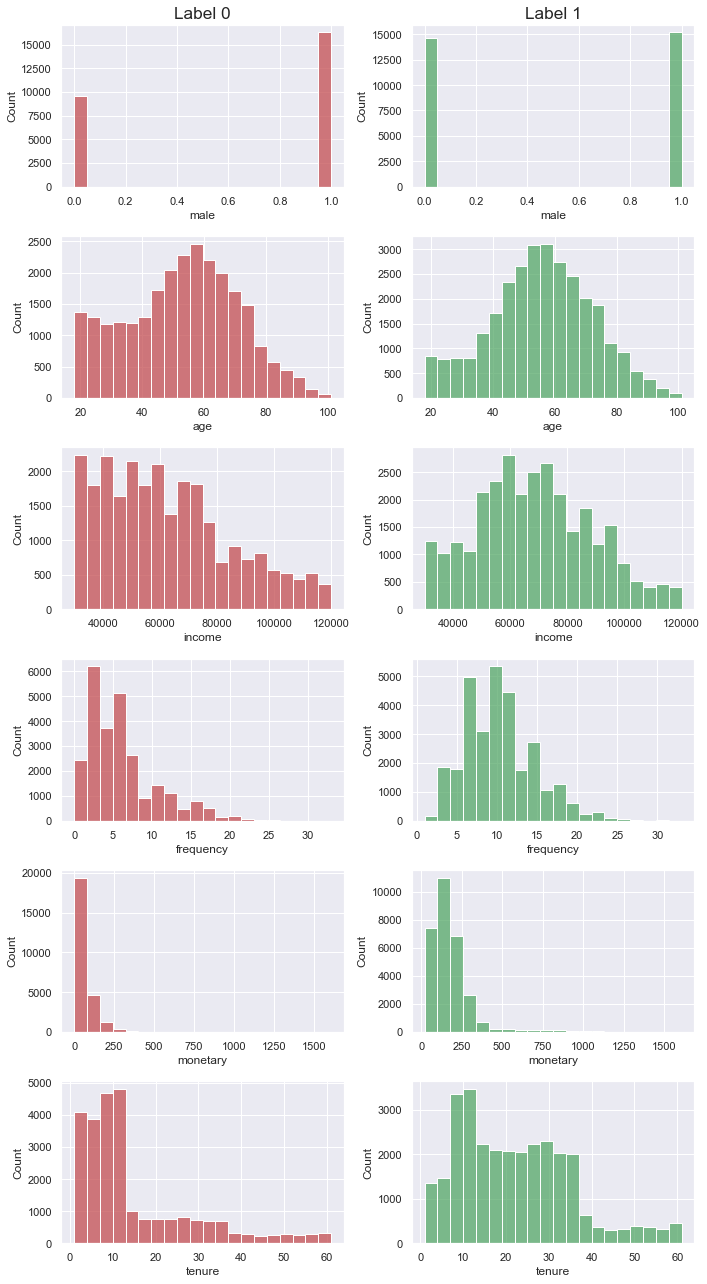

In [60]:
# Plot distribution for each feature by their predicted label
label0 = X.query('prediction == 0')
label1 = X.query('prediction == 1')
feats = ['male', 'age', 'income', 'frequency', 'monetary', 'tenure']

fig, ax = plt.subplots(6, 2, figsize=(10, 18))
ax[0, 0].set_title('Label 0', fontsize='x-large')
ax[0, 1].set_title('Label 1', fontsize='x-large')
for i in range(6):
    sns.histplot(x=label0[feats[i]], bins=20, color=sns.color_palette()[3], ax=ax[i, 0])
    sns.histplot(x=label1[feats[i]], bins=20, color=sns.color_palette()[2], ax=ax[i, 1])
plt.tight_layout()

In [59]:
del target_corr, label_means, label0, label1, feats, fig, ax, i
gc.collect()

53503

We can see that the classifier is capturing a lot of the same patterns seen in earlier analysis.
- Female customers are more likely to complete offers
- Customers under the `age` of 40 are more likely to NOT complete offers
- As `income` and spending habits increase, the customer is more likely to complete offers
- Users who have been using the app for more than a year are more likely to complete offers

## <a id="conc">Part IV: Conclusion</a>

I built a classifier that predicts whether a user will complete an offer or not. The process began with some data preprocessing, which included extracting the received offers, encoding the categorical variables into numerical data, creating the target label (defined as 1 if the user viewed and then completed the offer or 0 otherwise).

I also inspected feature correlation in order to create a separate feature set for logistic regression, which has an assumption of non-multicollinearity. The last step is to split the data into 3 sets and normalize the features in all 3 sets:
- Training set (50%) - used to fit the machine learning models
- Validation set (25%) - used to validate model building and parameter tuning
- Test set (25%) - holdout set for the final test

Out of the 5 models - [logistic regression](#clfr3), [k-nearest neighbors](#clfr4), [support vector machines](#clfr5), [decision tree](#clfr6), [random forest](#clfr7) - the random forest classifier is the best predictior with F1 score 0.74 on the validation set and 0.75 on the test set.

### Save data

In [61]:
df.to_pickle('../data/output3/train.pkl')
joblib.dump(scaler, '../data/output3/scaler.pkl')
joblib.dump(rf, '../data/output3/rfc.pkl')
df.shape

(55684, 17)